# Unsupervised Learning Trading Strategy

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [2]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

In [3]:
end_date = '2023-12-31'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers = symbols_list, start = start_date, end = end_date).stack()
df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      Volume  
Date                          
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

In [15]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956299   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     125.359337  
           AAL          NaN       NaN       NaN       NaN     470.599859  
           AAPL         NaN       NaN       NaN       NaN    6488.245944  
           ABBV         NaN       NaN       NaN       NaN     420.356642  
           ABT          NaN       NaN       NaN       NaN     451.883144  
...                     ...       ...       ...       ...            ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  0.784240     156.373892  
           ZBH     4.784470  4.815377 -1.054422  0.973531     103.396317  
           ZBRA    5.546306  5.676707 -0.154931  1.577769      68.687826  
           ZION    3.749483  3.887381  0.177122  2.099563      62.321720  
           ZTS     5.259449  5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

## Calculating features and technical indicators for each stock

In [5]:
# Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol  
Date                                            
2016-01-04 A       3287300.0         -0.001893  
           AAL    12037200.0         -0.000821  
           AAPL  270597600.0         -0.001233  
           ABBV   10308400.0         -0.047666  
           ABT    12227500.0         -0.010932  
...                      ...               ...  
2023-12-29 YUM     1196800.0          0.000030  
           ZBH      849600.0          0.000044  
           ZBRA     251300.0          0.000073  
           ZION    1420600.0          0.000102  
           ZTS     1007200.0          0.000035  

[994508 rows x 7 columns]

In [6]:
# RSI
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi  
Date                                                       
2016-01-04 A       3287300.0         -0.001893        NaN  
           AAL    12037200.0         -0.000821        NaN  
           AAPL  270597600.0         -0.001233        NaN  
           ABBV   10308400.0         -0.047666        NaN  
           ABT    12227500.0         -0.010932        NaN  
...                      ...               ...        ...  
2023-12-29 YUM     1196800.0          0.000030  59.338371  
           ZBH      849600.0          0.000044  68.767246  
           ZBRA     251300.0          0.000073  67.914673  
           ZION    1420600.0          0.000102  62.879829  
           ZTS     1007200.0          0.000035  66.791335  

[994508 rows x 8 columns]

<Axes: xlabel='Date'>

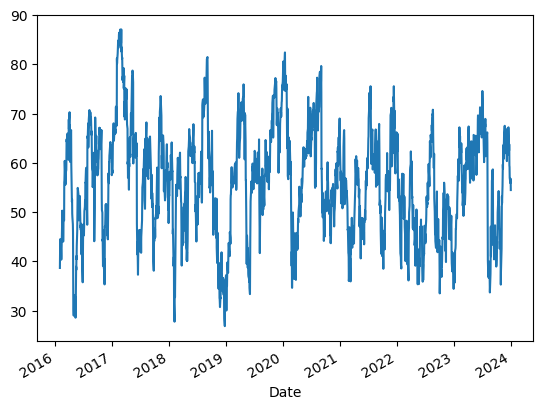

In [7]:
df.xs('AAPL', level = 1)['rsi'].plot()

In [8]:
# Bollinger Bands
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high  
Date                       
2016-01-04 A          NaN  
           AAL        NaN  
           AAPL       NaN  
           ABBV       NaN  
           ABT        NaN  
...                   ...  
2023-12-29 YUM   4.900952  
           ZBH   4.815377  
           ZBRA  5.676707  
           ZION  3.887381  
           ZTS   5.332449  

[994508 rows x 11 columns]

In [9]:
# ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr  
Date                                 
2016-01-04 A          NaN       NaN  
           AAL        NaN       NaN  
           AAPL       NaN       NaN  
           ABBV       NaN       NaN  
           ABT        NaN       NaN  
...                   ...       ...  
2023-12-29 YUM   4.900952 -0.073239  
           ZBH   4.815377 -1.054422  
           ZBRA  5.676707 -0.154931  
           ZION  3.887381  0.177122  
           ZTS   5.332449  0.420520  

[994508 rows x 12 columns]

In [10]:
# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr      macd  
Date                                           
2016-01-04 A          NaN       NaN       NaN  
           AAL        NaN       NaN       NaN  
           AAPL       NaN       NaN       NaN  
           ABBV       NaN       NaN       NaN  
           ABT        NaN       NaN       NaN  
...                   ...       ...       ...  
2023-12-29 YUM   4.900952 -0.073239  0.784240  
           ZBH   4.815377 -1.054422  0.973531  
           ZBRA  5.676707 -0.154931  1.577769  
           ZION  3.887381  0.177122  2.099563  
           ZTS   5.332449  0.420520  2.164720  

[994508 rows x 13 columns]

In [11]:
# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134438   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977470   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956299   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr      macd  dollar_volume  
Date                                                          
2016-01-04 A          NaN       NaN       NaN     125.359337  
           AAL        NaN       NaN       NaN     470.599859  
           AAPL       NaN       NaN       NaN    6488.245944  
           ABBV       NaN       NaN       NaN     420.356642  
           ABT        NaN       NaN       NaN     451.883144  
...                   ...       ...       ...            ...  
2023-12-29 YUM   4.900952 -0.073239  0.784240     156.373892  
           ZBH   4.815377 -1.054422  0.973531     103.396317  
           ZBRA  5.676707 -0.154931  1.577769      68.687826  
           ZION  3.887381  0.177122  2.099563      62.321720  
           ZTS   5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

## Filtering top 150 most liquid stocks for each month

In [18]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A           91.918050   35.004200 -0.932886  3.620122  3.522493   
           AAL        338.977810   39.288376  0.977081  3.729458  3.547833   
           AAPL      3548.073686   22.125887 -1.017466  3.155194  3.106253   
           ABBV       357.006459   39.060574 -0.477602  3.734669  3.638599   
           ABT        245.865716   33.559807 -0.797320  3.570935  3.483741   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        207.539266  130.660004 -0.073239  4.900952  4.824633   
           ZBH        207.682671  121.699997 -1.054422  4.815377  4.753563   
           ZBRA        98.037275  273.329987 -0.154931  5.676707  5.415905   
           ZION       102.724363   43.869999  0.177122  3.887381  3.611585   
           ZTS        335.154638  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-02-29 A       3.571307         -0.001914 -0.240045  48.107895  
           AAL     3.638645         -0.000319  0.529240  56.664362  
           AAPL    3.130723         -0.003013 -0.330066  48.335967  
           ABBV    3.686634         -0.049102 -0.288564  47.896402  
           ABT     3.527338         -0.009363 -0.394513  47.035038  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371  
           ZBH     4.784470          0.000044  0.973531  68.767246  
           ZBRA    5.546306          0.000073  1.577769  67.914673  
           ZION    3.749483          0.000102  2.099563  62.879829  
           ZTS     5.259449          0.000035  2.164720  66.791335  

[46953 rows x 9 columns]

In [19]:
# 5 Year rolling average of dollar volume for each stocks before filtering
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5 * 12, min_periods = 12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-01-31 AAL      42.760254  1.295678  3.891346  3.789144  3.840245   
           AAPL     28.233547 -1.191554  3.389455  3.332440  3.360948   
           ABBV     45.380970 -1.207862  3.877335  3.814875  3.846105   
           ABT      37.100910 -1.167994  3.643741  3.577130  3.610435   
           ACN     102.222725 -1.021878  4.667883  4.637933  4.652908   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.700001 -1.182997  3.681654  3.632663  3.657159   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-01-31 AAL            -0.000522 -0.163933  42.277640  
           AAPL           -0.001885 -0.108144  67.547636  
           ABBV           -0.029823 -0.322387  49.245577  
           ABT            -0.002947  0.206063  66.810962  
           ACN            -0.004494 -0.450311  41.080195  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000028  3.205584  65.899356  
           VZ              0.000041  0.466400  57.985190  
           WFC             0.000025  1.913446  67.347850  
           WMT             0.000017 -0.274379  52.372668  
           XOM             0.000041 -0.683288  42.607132  

[12516 rows x 8 columns]

In [20]:
# Monthly Returns for different time horizons as features
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
        return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-02-28 AAL      44.898849  0.191922  3.864723  3.767394  3.816059   
           AAPL     32.010571 -1.169208  3.528788  3.405187  3.466988   
           ABBV     45.923088 -1.526215  3.856999  3.819668  3.838334   
           ABT      40.040913 -1.270619  3.738760  3.629050  3.683905   
           ACN     109.970016 -1.094677  4.735125  4.617836  4.676480   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.700001 -1.182997  3.681654  3.632663  3.657159   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   garman_klass_vol      macd        rsi  return_1m  
date       ticker                                                    
2017-02-28 AAL            -0.000264  0.099045  50.168952   0.050014  
           AAPL           -0.001782  0.183176  84.344683   0.133778  
           ABBV           -0.035152 -0.132129  53.680511   0.011946  
           ABT            -0.006028  0.696259  71.877138   0.079243  
           ACN            -0.004624  0.192998  63.223045   0.075788  
...                             ...       ...        ...        ...  
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783  
           VZ              0.000041  0.466400  57.985190  -0.016436  
           WFC             0.000025  1.913446  67.347850   0.103835  
           WMT             0.000017 -0.274379  52.372668   0.016350  
           XOM             0.000041 -0.683288  42.607132  -0.026864  

[12331 rows x 9 columns]

## Fama-French Factors and Calculate Rolling Factor Betas

In [21]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AAL     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.050014
           AAPL    0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.133778
           ABBV    0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.011946
           ABT     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.079243
           ACN     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.075788
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[12182 rows x 6 columns]

In [22]:
# filtering out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AAL     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.050014
           AAPL    0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.133778
           ABBV    0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.011946
           ABT     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.079243
           ACN     0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.075788
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[12134 rows x 6 columns]

In [23]:
# Calculating Rolling Factor Betas
betas = (factor_data.groupby(level = 1, group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m', axis=1)), window=min(24, x.shape[0]), min_nobs=len(x.columns)+1)
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-02-28 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444391 -0.662956  0.517150  0.210200 -0.205922
           WFC     1.037896  0.401001  2.011853 -0.363960 -1.477539
           WMT     0.497264  0.081985 -0.731000  0.577485  0.752986
           XOM     0.722589 -0.210772  1.202657  0.229339  0.172210

[12134 rows x 5 columns]

In [24]:
# Joining the Rolling Factors data to the main dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11998 entries, (Timestamp('2017-02-28 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'XOM')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               11998 non-null  float64
 1   bb_high           11998 non-null  float64
 2   bb_low            11998 non-null  float64
 3   bb_mid            11998 non-null  float64
 4   garman_klass_vol  11998 non-null  float64
 5   macd              11998 non-null  float64
 6   rsi               11998 non-null  float64
 7   return_1m         11998 non-null  float64
 8   Mkt-RF            11998 non-null  float64
 9   SMB               11998 non-null  float64
 10  HML               11998 non-null  float64
 11  RMW               11998 non-null  float64
 12  CMA               11998 non-null  float64
dtypes: float64(13)
memory usage: 1.2+ MB


In [26]:
# K-Means Clustering Algorithm (Months) to group similar assets based on their features
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

KeyError: "['cluster'] not found in axis"